In [1]:
import dirfile_functions as df
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd

In [2]:
roach_path = 'roach_data/'
ancillary_path = 'xy_stage/'

In [3]:
# Load some data, using both the dirfile functions and the direct method.  Compute both amplitude and phase.
I, Q = df.loadIQsingleChan(roach_path, 1)
d_roach = gd.dirfile(roach_path, gd.RDWR|gd.UNENCODED)
mag = np.sqrt(I**2 + Q**2)
phs = np.arctan2(Q,I)

In [4]:
# Get the x-y stage data
d_anc = gd.dirfile(ancillary_path, gd.RDWR|gd.UNENCODED)
x_stage = d_anc.getdata('x_stage', gd.FLOAT32)#, num_frames = d.nframes)
y_stage = d_anc.getdata('y_stage', gd.FLOAT32)

In [5]:
# Generate the time axis appropriate for each variable under the assumption I know the sample rates
t488 = np.arange(len(Q))/488.
t5 = np.arange(len(x_stage))/5.

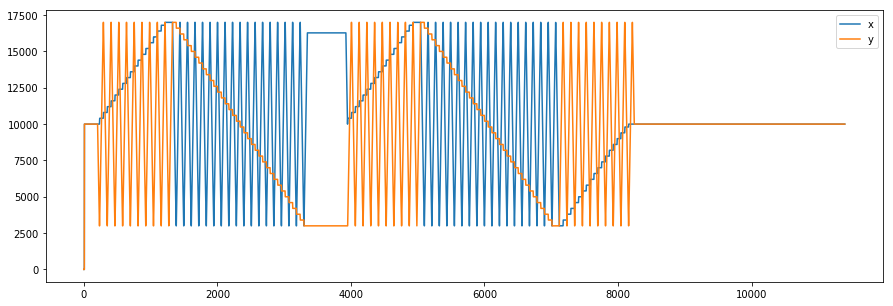

In [7]:
# Plot the x and y stage positions versus time
%matplotlib inline
plt.figure(figsize=(15,5))
plt.plot(t5,x_stage,label='x')
plt.plot(t5,y_stage,label='y')
plt.legend()
plt.show()

This scan pattern is just weird.  It looks like x moves over half its range in slow steps, with fast y scanning, then we switch to fast x scanning while y moves down slowly to the edge of its range, then y scans fast while x moves over the other part of the range.  It also looks like this pattern repeats not quite twice. 

<IPython.core.display.Javascript object>


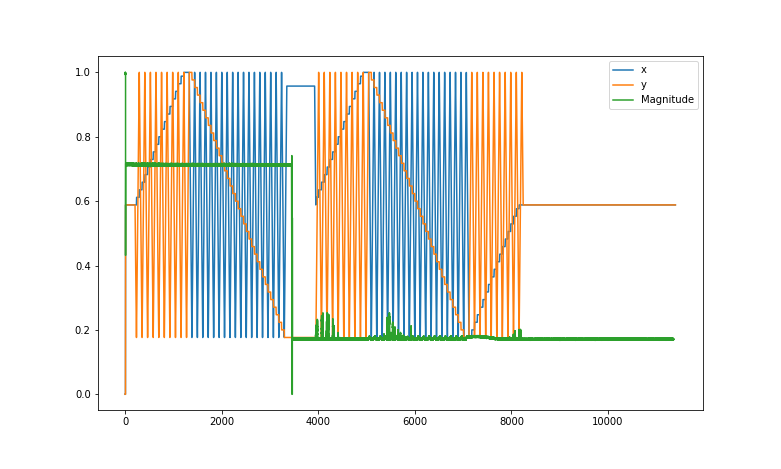

In [16]:
# Plot the signal on the x-y stage motions (channel 1)
%matplotlib notebook
#plt.figure(figsize=(15,5))
plt.plot(t5,x_stage/x_stage.max(),label='x')
plt.plot(t5,y_stage/y_stage.max(),label='y')
plt.plot(t488,mag/mag.max(),label='Magnitude')
plt.legend()
plt.show()

I don't see evidence for any signal in the first scan pattern.  There _is_ signal in the second, but as we'll see below, the pattern for when it appears doesn't make sense.

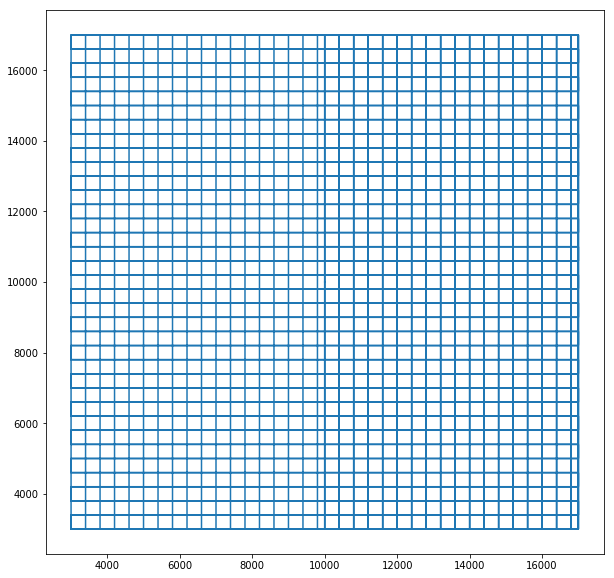

In [17]:
# Here's what it looks like plotted x versus y
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(x_stage[x_stage > 0],y_stage[x_stage > 0])
plt.show()

In [173]:
tmin = 5000
tmax = 7100
whgood5 = np.logical_and(t5 > tmin, t5 < tmax)
whgood488 = np.logical_and(t488 > tmin+1, t488 < tmax-1)

<IPython.core.display.Javascript object>


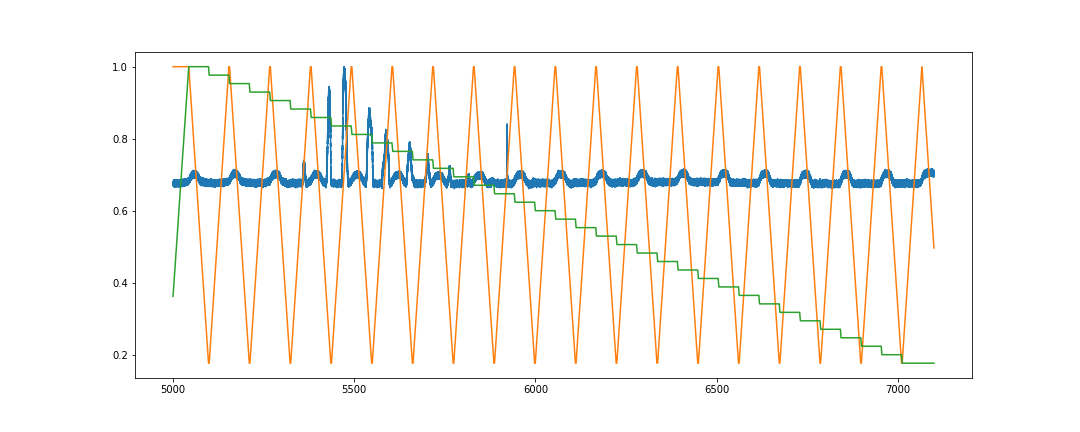

In [212]:
%matplotlib notebook
plt.figure(figsize=(15,6))
plt.plot(t488[whgood488],mag[whgood488]/m.max())
plt.plot(t5[whgood5],x_stage[whgood5]/x_stage.max())
plt.plot(t5[whgood5],y_stage[whgood5]/y_stage.max())
plt.show()

In [117]:
from scipy.interpolate import interp1d

In [197]:
# It really looksl like there was a stage scan where no data came through
t_s5 = t5[whgood5]
x_s = interp1d(t_s5, x_stage[whgood5], kind='nearest')
y_s = interp1d(t_s5, y_stage[whgood5], kind='nearest')

In [198]:
# This is now _the_ time base
t = t488[whgood488]
m = mag[whgood488]
p = mag[whgood488]

In [199]:
print t.min()
print t.max()
print t_s5.min()
print t_s5.max()

5001.002049180328
7098.997950819672
5000.2
7099.8


<IPython.core.display.Javascript object>


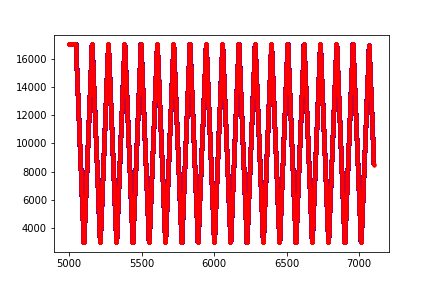

In [200]:
%matplotlib notebook
plt.plot(t,x_s(t),'b.')
plt.plot(t_s5,x_stage[whgood5],'r.')
plt.show()

<IPython.core.display.Javascript object>


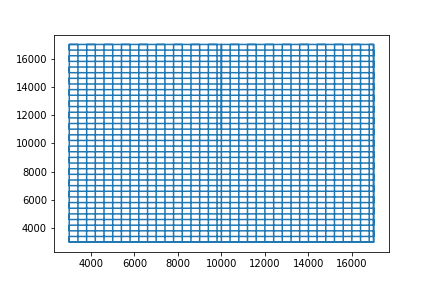

In [158]:
%matplotlib notebook
plt.plot(x_s(t),y_s(t))
plt.show()

In [201]:
# There's probably a better way to determine this based on the gradient in x,y 
# but it looks like the grid is about 250 x 250 in some units
ds = 100.
xpix = np.arange(x_s(t).min(),x_s(t).max(),ds)
ypix = np.arange(y_s(t).min(),y_s(t).max(),ds)

In [202]:
from scipy.interpolate import griddata

In [203]:
#%%time
#zi = griddata((x_s(t), y_s(t)), m, (xpix[None,:], ypix[:,None]), method='nearest')

In [204]:
#%matplotlib notebook
#plt.imshow(zi,aspect='auto')
#plt.show()

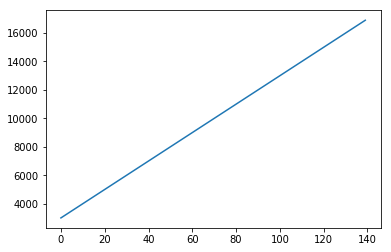

In [205]:
%matplotlib inline
plt.plot(xpix)

In [206]:
from scipy.stats import binned_statistic_2d as gridmap

In [207]:
%%time
ret = gridmap(x_s(t), y_s(t), m, 'mean',bins=30)#, bins=140)

CPU times: user 201 ms, sys: 20 ms, total: 221 ms
Wall time: 220 ms


<IPython.core.display.Javascript object>


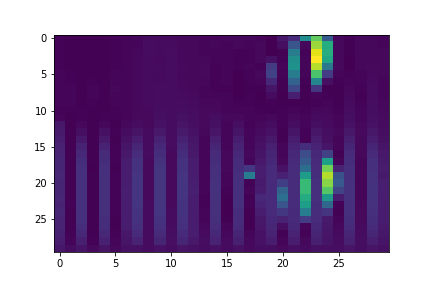

In [208]:
%matplotlib notebook
plt.imshow(ret.statistic,aspect='auto')
plt.show()

<IPython.core.display.Javascript object>


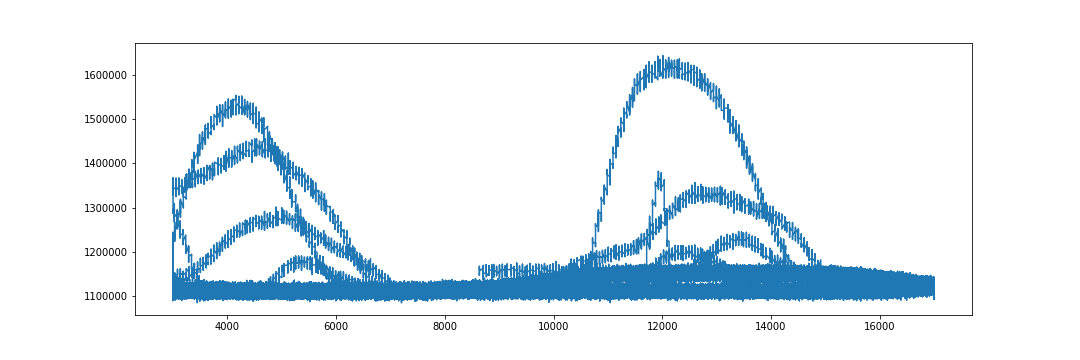

In [211]:
%matplotlib notebook
plt.figure(figsize=(15,5))
plt.plot(x_s(t),m)
plt.show()